# Accumulate Local Effects  Documentation

This notebook is designed to demonstrate how to use `mintpy` to compute 1D or 2D partial dependence and plot the results. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import numpy as np
import pandas as pd
from joblib import load 

import mintpy
import plotting_config 

## Loading the training data and pre-fit models 

In [2]:
# Load the model objects. In this case, we are using two popular scikit-learn tree-based methods.
model_filepath = os.path.join(current_dir, 'models')
model_fname = ['RandomForestClassifier.pkl',  'GradientBoostingClassifier.pkl']
model_names = ['Random Forest', 'Gradient Boosting']
model_objs = [load(os.path.join(model_filepath, fname)) for fname in model_fname]

#Import the training dataset
data_filename = os.path.join(current_dir, 'data', 'data_for_mintpy.csv')

# Load the examples the models were trained on.
TARGET_COLUMN = 'cat_rt'
data  = pd.read_csv(data_filename)

examples = data[plotting_config.cols_to_use]
targets = data[TARGET_COLUMN].values

print(f'Examples Shape : {examples.shape}')
print(f'Target Skew : {targets.mean()*100}%')

Examples Shape : (100000, 30)
Target Skew : 39.173%


## Loading feature rankings for a list of features to explore with ALE

In [3]:
results_filepath = os.path.join(current_dir, 'results')
myInterpreter = mintpy.InterpretToolkit(model=model_objs,
                                 model_names=model_names,
                                 examples=examples,
                                 targets=targets,
                                )

# Load the permutation important results from the saved pickle file
results = myInterpreter.load_results(fnames=os.path.join(results_filepath,'multipass_importance.pkl'), 
                                     option='permutation_importance',
                                    model_names=model_names)

print(results)
important_vars = myInterpreter.get_important_vars(results, multipass=True, nvars=7)

{'Gradient Boosting': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7faa917eab70>, 'Random Forest': <mintpy.main.PermutationImportance.result.ImportanceResult object at 0x7faab0bf7a90>}


# Accumulated Local Effect Plots

Once we known what features are important, we explore their functional relationship with the target variable. MintPy has a built-in function to take the important features from multiple model turn it into a single list with any duplicate features removed. 

Using 10 processors...


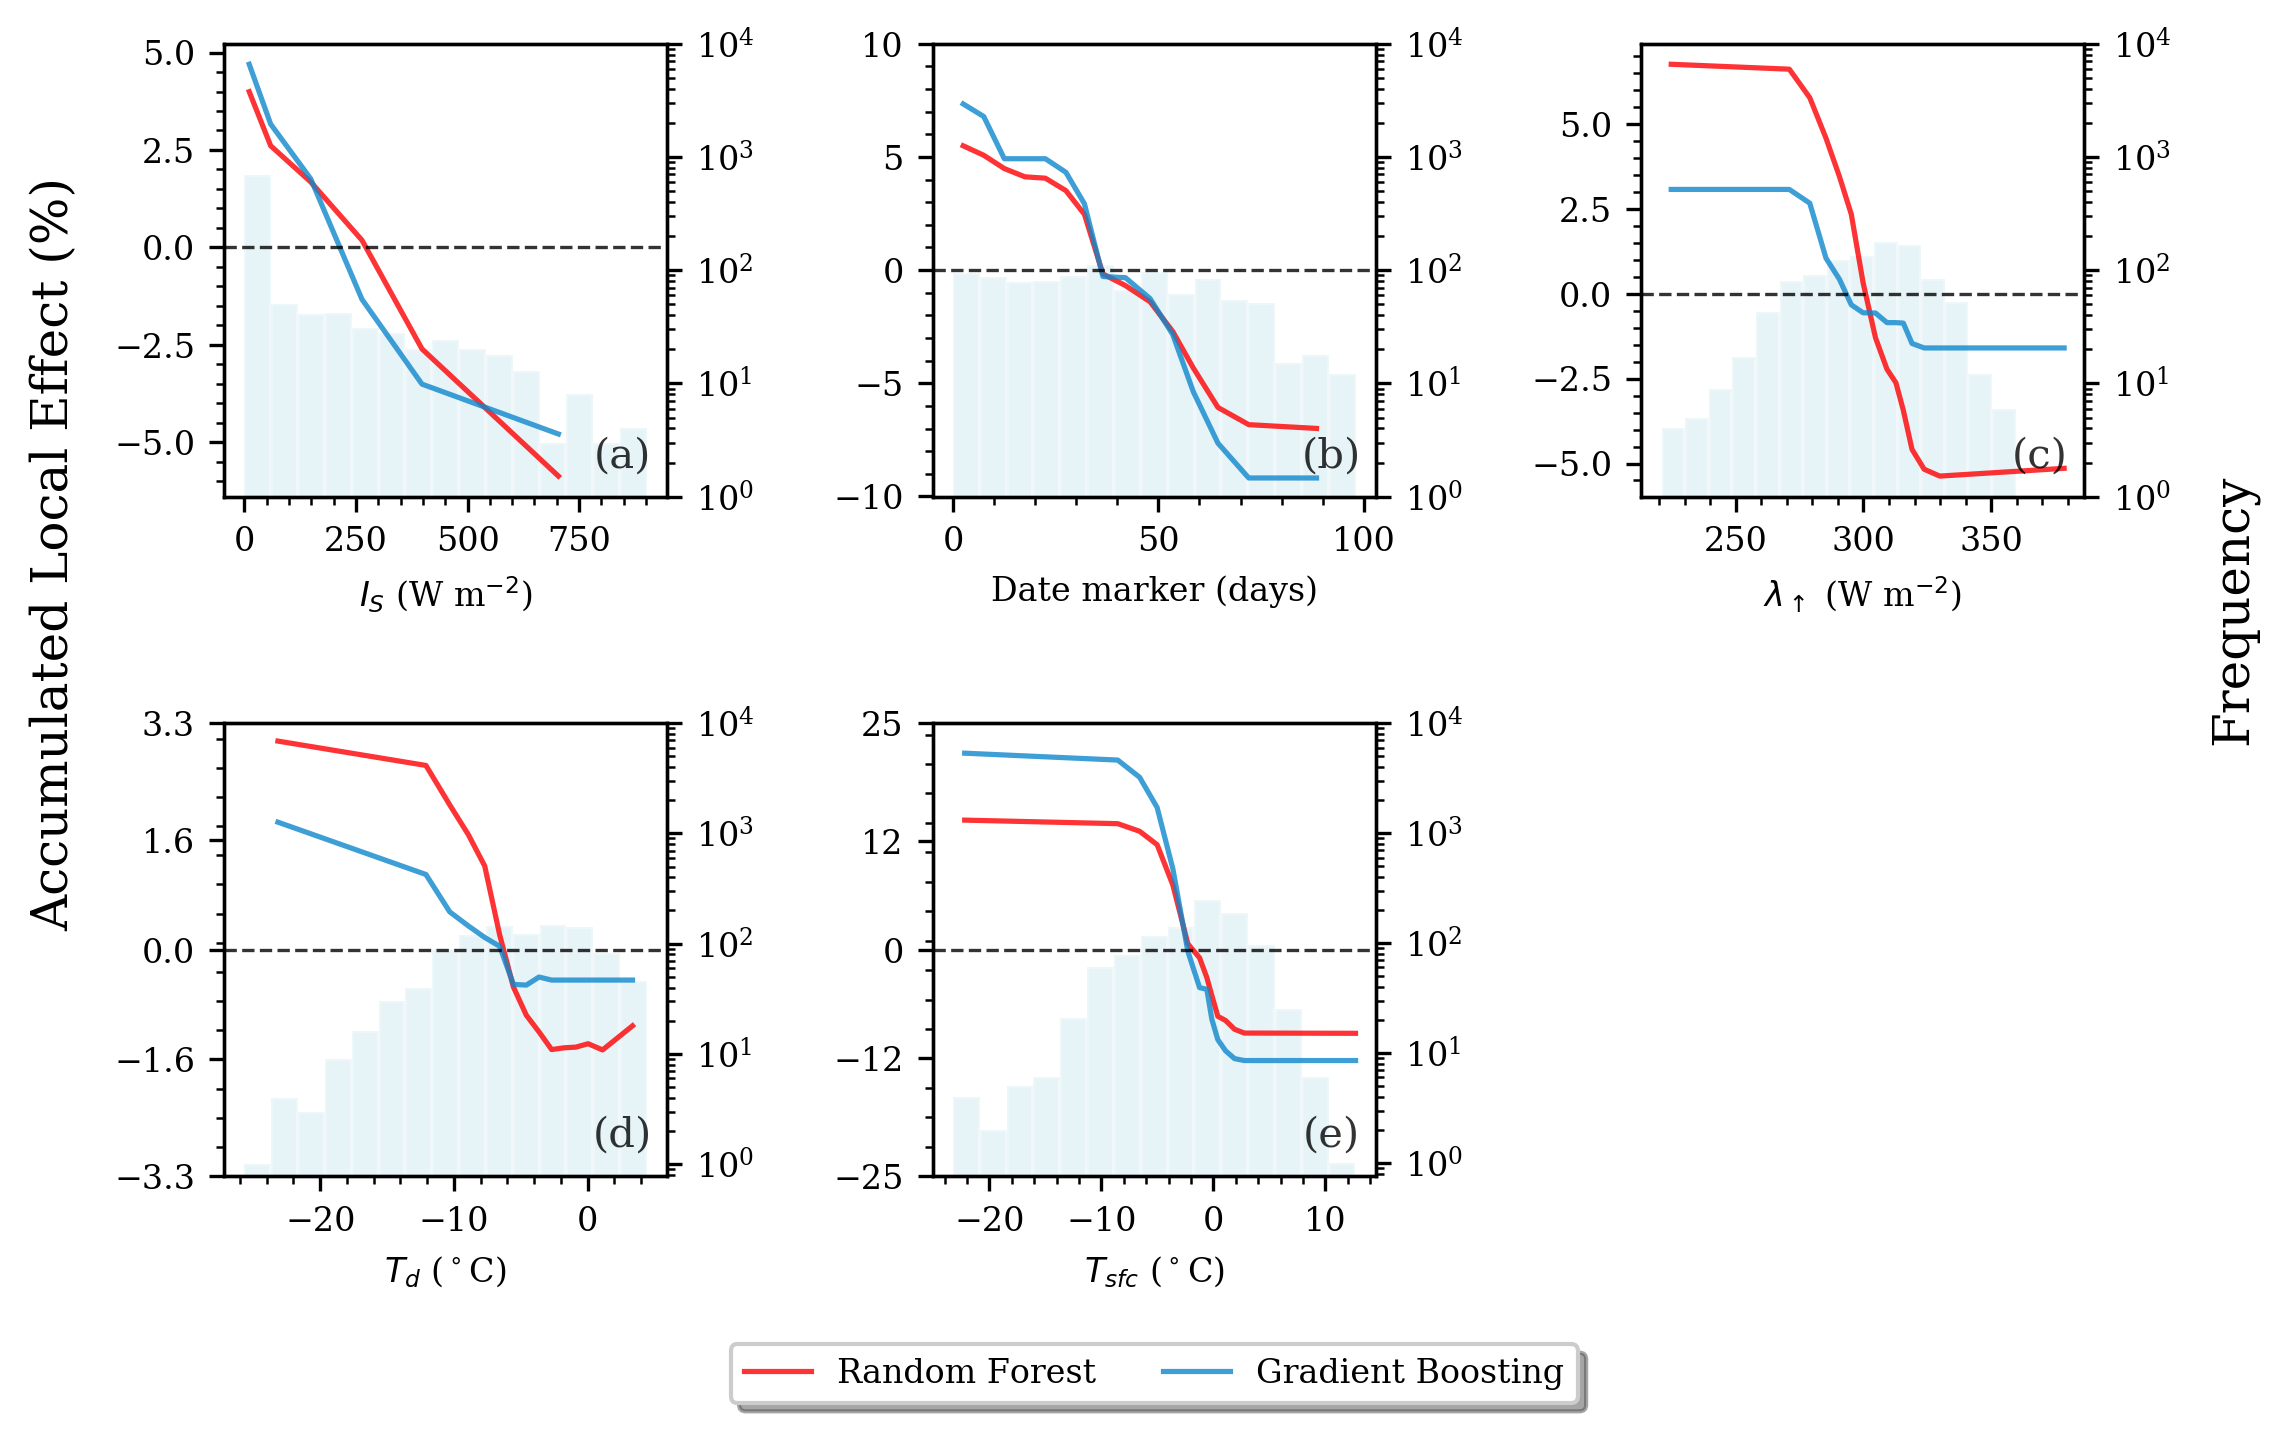

In [4]:
important_vars = important_vars[:5]

results = myInterpreter.calc_ale(features=important_vars, 
                                 nbootstrap=1, 
                                 subsample=0.01, 
                                 njobs=len(important_vars)*len(model_objs), 
                                 nbins=15
                                )

fig, axes = myInterpreter.plot_ale(feature_units=plotting_config.feature_units,
                                   readable_feature_names=plotting_config.readable_feature_names
                                  )